<a href="https://colab.research.google.com/github/JoDeMiro/SACI22/blob/main/SACI22_019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Források

Kaggle EUR USD Historical Data:
https://www.kaggle.com/imetomi/eur-usd-forex-pair-historical-data-2002-2019

Scikit Learn MLPRegressor:
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Itt olyan jó leírások vannak ezt be kelett volna tennem a cikkbe.

### Módosítás a SACI22 - 01.ipynb-hez képest

1. nem feltöltéssel rakom fel az adatot
2. a Github repoból szedi le
3. nem a teljes adatsort, hanem egy rövidített változatot (n < 1110)

### Módosítás a SACI22 - 02.ipynb-hez képest

1. Normalizáció (0,1) helyett (-1,1)-re
2. Az mlp súlyait újra lehet inicializálni az `initializer(mlp, factor)` segítségével.
3. Az mlp első illesztésénél teljesen **random** adatokra illesztek az `y_test` helyett.
4. ezek a listák tárolják az evolúció egyes értékeit (csak elezés céljából)
 - generation_holder = [ ]
 - population_holder = [ ]
 - best_indiv_holder = [ ]
 - best_score_holder = [ ]
   <br>
   ezek a listák tárolják az evolúció egyes értékeit (csak elezés céljából)

### Modósítás a SACI22 - 03.ipynb-hez képest
1. Ez csak egy jó futás - működik. A paraméterek miatt fraction = 25
2. Bevezettem az időmérést
3. Bevezettem a plottolásnál a végtelenűl nagy (értelmezhetetlen értékek) szűrését.
4. Ugyan az mint 03 (013) csak a nagyobb adatokon tesztelgetem, hogy mennyire lassul be.
5.  - **BugFix** (valahol van egy nem kezelt randomizáció) <br>
Az első illesztéshez gyártott random változónál volt egy nem kezelt véletlen.

### Modósítás a SACI22 - 04.ipynb-hez képest
1. Visszatérés a rövid adatokhoz (n=1000)
2. Megcsinálja mind a 10 változóra az időablakot, de nem használom
3. Néhány kiegészítő számítás az adatok méretére a cikkhez.
4. Keep_best solution bevezetése.

### Modósítás a SACI22 - 05.ipynb-hez képest
1. Beletettem egy kíséletet, ahol azt csinálom, hogy folyamatosan növelem a neuronok számát és mérem, hogy mennyivel lessz lassabb a futás.

### Modósítás a SACI22 - 06.ipynb-hez képest
1. Az 1 millió adatot tartalmazó filét olvasom be, jelenleg kísérletezem azzal milyen képeket lehetne betenni a cikkbe.
2. - **BugFix** (a mlp setup batch_size=1, miatt lassú az inicializáló fit - átállítottam max-ra

### Modósítás a SACI22 - 18.ipynb-hez képest
1. - **BugFix** (itt található a pontos leírása annak a jelenségnek, hogy azonos Ranodom Number esetén is miért alakul másképp a tanulás különböző méretű populációkban. Nagyon **Fontos** teoretikus írás, ugyanis a jelenség nem hiba.
2. Elkezdtem átírni az `evaluation` függvényt az `Evaluator` osztályba.
3. - **Nagyon Fontos**  mivel a **SACI22** GitHub Projectet áttettem **Private** elérésbe, ezért ebben a Notebookban az adatokat már a másik GitHub Projectből **SACI2022** olvasom be.

### Figyelem

Direkt nem neveztem át a Github repoba kerülő file nevét, hogy ne kelljen a kódon változtatnom, de ez a file az eredeti adatoknak csak egy töredékét tartalmazza.

## Ez cloud init-be megy majd.

In [1]:
# ------------------------------------------------------------------------------

!mkdir input
# !unzip archive.zip -d input
# !wget https://raw.githubusercontent.com/JoDeMiro/SACI22/main/Input/eurusd_minute_1000000.csv.gz     # <-- saját project
!wget https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_1000000.csv.gz     # <-- másik project
!mv eurusd_minute_1000000.csv.gz ./input/
!cd input
!gzip -f -d ./input/eurusd_minute_1000000.csv.gz
!rm ./input/eurusd_minute.csv
!mv ./input/eurusd_minute_1000000.csv ./input/eurusd_minute.csv

# ------------------------------------------------------------------------------

--2022-03-08 16:02:34--  https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_1000000.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12887930 (12M) [application/octet-stream]
Saving to: ‘eurusd_minute_1000000.csv.gz’

eurusd_minute_10000 100%[===================>]  12.29M  --.-KB/s    in 0.09s   

2022-03-08 16:02:35 (144 MB/s) - ‘eurusd_minute_1000000.csv.gz’ saved [12887930/12887930]

rm: cannot remove './input/eurusd_minute.csv': No such file or directory


In [2]:
import os
import sys
import pprint
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor

print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__)) 

Python version:3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
Numpy version:1.21.5
Pandas version:1.3.5
Sci-Kit Learn version:1.0.2


In [3]:
print(os.listdir('./input'))

['eurusd_minute.csv']


## Data Reader Class

In [10]:
from matplotlib.image import NonUniformImage
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

class DataReader():

  def __init__(self, nRowsRead):
    self.nRowsRead = nRowsRead
    self.dataset = None
    self.dataset_full = None
    self.window = NonUniformImage

# ------------------------------------------------------------------------------

  def load_with_pandas(self, path = './input/eurusd_minute.csv'):
    self.df2 = pd.read_csv(path, delimiter=',', nrows = self.nRowsRead)             # <-- read csv to pandas dataframe
    self.df2.dataframeName = 'eurusd_minute.csv'

    self.n_row, self.n_col = self.df2.shape
    print(f'There are {self.n_row} rows and {self.n_col} columns')                  # <-- print nRow, nCol
    print(self.df2.head(5))                                                         # <-- print head
    self.println()

    return self.df2

# ------------------------------------------------------------------------------

  def info(self):
    print('Info:')
    print(self.df2.BC.values.ctypes)
    print(self.df2.BC.values.dtype)
    print(self.df2.BC.values.itemsize)
    print(self.df2.BC.values.nbytes)

    print('BC.nbytes =', self.df2.BC.values.nbytes)
    print('BC.nbytes =', self.df2.BC.values.nbytes / 1000, 'Kbyte')
    self.println()

# ------------------------------------------------------------------------------

  def prepare_data(self):
    self.df = self.df2

    # For BC column only
    self.df.set_index(['Date'], inplace=True)              # <-- set index column
    self.data = self.df.filter(['BC'])                     # <-- select only the BC column
    self.dataset = self.data.values                        # --> from pandas.series -> numpy.ndarray

    # For all column (I do not use it)
    data_full = self.df.filter(['BO', 'BH', 'BL', 'BC', 'BCh', 'AO', 'AH', 'AL', 'AC', 'ACh'])
    self.dataset_full = data_full.values                   # --> from pandas.series -> numpy.ndarray

# ------------------------------------------------------------------------------

  def show_dataset_info(self):
    self.println()
    print(type(self.dataset))
    print(type(self.dataset_full))
    print(self.dataset.shape)
    print(self.dataset_full.shape)
    self.println()

# ------------------------------------------------------------------------------

  def normalize_values(self):
    
    self.scaler        = MinMaxScaler(feature_range=(-1, 1))                        # <-- (0, 1) vagy (-1, 1)
    self.scaled_data   = self.scaler.fit_transform(self.dataset)

    self.scaler_full        = MinMaxScaler(feature_range=(-1, 1))                   # <-- (0, 1) vagy (-1, 1)
    self.scaled_data_full   = self.scaler_full.fit_transform(self.dataset_full)

# ------------------------------------------------------------------------------

  def set_window(self, value: int):
    if type(value) is int:
      self.window = value
      print('Set window =', self.window)
    else:
      print('Error: Not proper type of parameter')
    self.println()


# ------------------------------------------------------------------------------

  def create_train_set(self):
    self.x_train = []                                                               # <-- Create list of Windows
    self.y_train = []

    for i in range(self.window, len(self.scaled_data)):
        self.x_train.append(self.scaled_data[i-self.window:i, 0])
        self.y_train.append(self.scaled_data[i, 0])

    print('The train dataset {}, and the labels {}'.format(len(self.x_train), len(self.y_train)))

    self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)     # <-- Convert list to Numpy Array

    print(self.x_train.shape)
    print(self.y_train.shape)

    print('x_train.nbytes = ', self.x_train.nbytes/1000, 'Kbyte')
    print('x_train.nbytes = ', self.x_train.nbytes/1000/1000, 'Mbyte')

    self.x_train_reshaped = np.reshape(self.x_train,                                # <-- Nagyon fontos az adatokat az alábbi formában várjuk
                                       newshape=(self.x_train.shape[0],
                                                 self.x_train.shape[1], 1))         # <-- Reshape (970, 30) -> (970, 30, 1)
    
    print(self.x_train_reshaped.shape)
    print(self.x_train.shape)
    print(self.y_train.shape)
    self.println()


    # --------------------------------------------------------------------------    # <-- ToDo: ezt itt hagyom de nem használom, nem is adom az obj-hez

    x_train_full = []                                                               # <-- Create list of Windows
    y_train_full = []

    for i in range(self.window, len(self.scaled_data_full)):
        x_train_full.append(self.scaled_data_full[i-self.window:i, :])
        y_train_full.append(self.scaled_data_full[i, 0])

    # print('The train dataset {}, and the labels {}'.format(len(x_train_full), len(y_train_full)))

    x_train_full, y_train_full = np.array(x_train_full), np.array(y_train_full)     # <-- Convert list to Numpy Array

    # print(x_train_full.shape)
    # print(y_train_full.shape)

    # print('x_train_full.nbytes = ', x_train_full.nbytes/1000, 'Kbyte')
    # print('x_train_full.nbytes = ', x_train_full.nbytes/1000/1000, 'Mbyte')

# ------------------------------------------------------------------------------

  def println(self):
    print('------------------------------------------------------------------------------')



## Program

In [11]:
# ------------------------------------------------------------------------------

data_reader = DataReader(nRowsRead=1000)                                        # <-- instantiate DataReader (set number of rows for data)

df2 = data_reader.load_with_pandas(path = './input/eurusd_minute.csv')          # <-- read a particular files from disk (return with df, but also set self)

data_reader.info()                                                              # <-- my own info() function

data_reader.df2.info()                                                          # <-- call pandas built-in info() function

data_reader.prepare_data()                                                      # <-- prepare is setter convert pandas to numpy and set target variable

data_reader.show_dataset_info()

data_reader.normalize_values()                                                  # <-- transform data between range (-1,1)

data_reader.set_window(2)                                                       # <-- set window size

data_reader.create_train_set()                                                  # <-- prepare egyik legfontossab metódusa (sok transzformációval)



There are 1000 rows and 12 columns
         Date   Time      BO      BH      BL      BC  BCh      AO      AH  \
0  2005-01-02  18:29  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
1  2005-01-02  18:38  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2  2005-01-02  18:51  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
3  2005-01-02  18:52  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
4  2005-01-02  18:55  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

       AL      AC  ACh  
0  1.3565  1.3565  0.0  
1  1.3565  1.3565  0.0  
2  1.3572  1.3572  0.0  
3  1.3570  1.3570  0.0  
4  1.3573  1.3573  0.0  
------------------------------------------------------------------------------
Info:
float64
8
8000
BC.nbytes = 8000
BC.nbytes = 8.0 Kbyte
------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count 

### Check Point

Csak a Jupyter Notebookba kerül be a telepített programba nem.


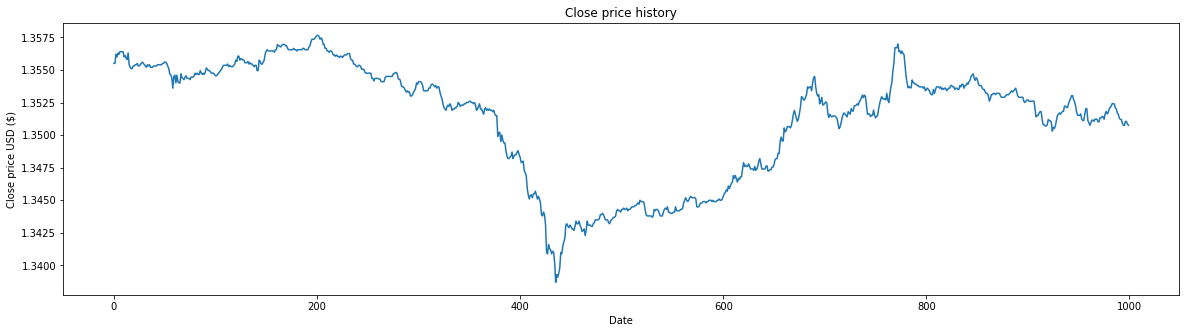

In [12]:
plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.dataset)
plt.xlabel('Date')
plt.ylabel('Close price USD ($)')
plt.show()

## NN osztály

Ez egy érdekes állat lesz, mert a **Driver** és a **Worker** is használni fogja.



In [13]:
# ------------------------------------------------------------------------------    # <-- NN Class

# Neural Network Class

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)                                 # <-- kell a Convergencia Warning miatt
simplefilter("ignore")                                                              # <-- a batch_size > n miatt kell ide

import numpy as np
from sklearn.neural_network import MLPRegressor

# ------------------------------------------------------------------------------

class NN():

  def __init__(self, x_train, y_train):
    self.mlp = None
    self.x_train = x_train
    self.y_train = y_train
    self.prediction = None

# ------------------------------------------------------------------------------
  
  def init_nn(self, _first = 15, _second = 5):
    'Init Scikit Learn MLPRegressor'                                                 # <-- hogy létre jöjjenek a súlyok inicializálni kell
    
    np.random.seed(1)

    mlp = MLPRegressor(hidden_layer_sizes=(_first, _second),
                      activation='tanh',                                             # -------> ha (MinMax(-1,1) vagy StandardScaler())
                      solver='sgd',
                      batch_size=100000,                                             # <<-- v.017 bug fixed
                      max_iter=1,                                                    # <-- sajnos legalább 1 kell hogy legyen
                      shuffle=False,
                      random_state=1,
                      learning_rate_init=0.00000001,                                 # >- lehetőleg ne tanuljon semmit GD alapján
                      validation_fraction=0.0,
                      n_iter_no_change=99999999)
    
    # ----->                                                         Behoztam ide az első illesztést is, hogy meglegyenek neki a súlyok

    np.random.seed(1)

    y_random = np.zeros((self.y_train.shape[0])) * 110.01                           # --> tök random adaton tanítom, hogy még véletlenül se tanuljon

    mlp.fit(self.x_train, y_random)                                                 # --> nem akarjuk mi semmire megtanítani csak kell az inithez

    self.mlp = mlp
    
    return mlp

# ------------------------------------------------------------------------------

  def create_prediction(self):
    'Saját adati alapján csinája meg a predcitiont'

    self.prediction = self.mlp.predict(self.x_train)

    return self.prediction


## Program

In [14]:
# ------------------------------------------------------------------------------

nn = NN(x_train = data_reader.x_train, y_train = data_reader.y_train)

nn.init_nn(_first = 15, _second = 5)

# nn.mlp.coefs_                                                                     # <-- ha debuggolni kell


# ------------------------------------------------------------------------------

# Create Prediction

mlp = nn.init_nn(2, 2)

test_pred = mlp.predict(data_reader.x_train)                                        # teszt pred --> semmire nem fogjuk használni

print(test_pred[0:5])

test_pred = nn.mlp.predict(data_reader.x_train)                                     # init után direktben is el lehet érni az mlp.predict() függvényt

print(test_pred[0:5])

test_pred = nn.create_prediction()                                                  # csináltam neki egy saját fügvényt ami elvégzi az egész predictiont

print(test_pred[0:5])

# ------------------------------------------------------------------------------

# A scikit-től eltérő súlyincializácóra van lehetőség létre hoztam rá egy
# eljárást de nem használom. Ha mégis használni szeretném akkor a
# SACI22 - 018.ipynb-ben megtalálható

# ------------------------------------------------------------------------------


[-1.17970488 -1.18359979 -1.17930595 -1.18190242 -1.17996159]
[-1.17970488 -1.18359979 -1.17930595 -1.18190242 -1.17996159]
[-1.17970488 -1.18359979 -1.17930595 -1.18190242 -1.17996159]


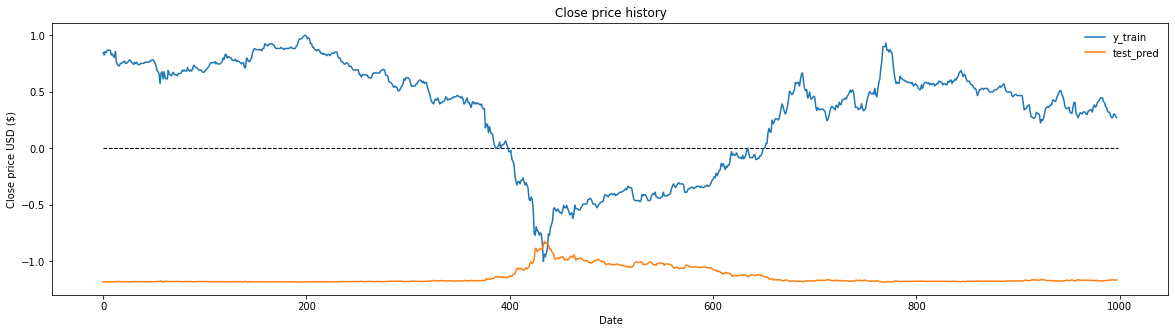

In [15]:
plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.y_train, label = 'y_train')
plt.plot(test_pred, label = 'test_pred')
plt.xlabel('Date')
plt.ylabel('Close price USD ($)')
plt.hlines(0.0, 0, data_reader.y_train.size, lw = 1, linestyles='dashed')
plt.legend(frameon=False)
plt.show()

## Trader osztály

In [16]:
# ------------------------------------------------------------------------------    # <-- Trader Class

# Trader Calculator Class

import numpy as np

class Trader():

  def __init__(self, threshold, data_reader, debug = False):
    self.threshold = threshold
    self.data_reader = data_reader
    self.debug = debug
    print('__init__ Trader')

  def calculator(self, pred):
    buy   = pred > self.threshold
    sell  = pred < self.threshold

    sunique, scounts = np.unique(sell, return_counts=True)
    sell_stat = dict(zip(sunique, scounts))

    bunique, bcounts = np.unique(buy, return_counts=True)
    buy_stat = dict(zip(bunique, bcounts))

    lenght = pred.size

    is_in_trade = False
    is_in_buy = False
    buy_count = 0
    sell_count = 0
    buy_price = []
    sell_price = []
    buy_index = []
    sell_index = []
    for i in range(lenght):
      if buy[i] == True and is_in_trade == False:
        buy_count += 1
        buy_price.append(self.data_reader.y_train[i])
        buy_index.append(i)
        is_in_trade = True
      
      if sell[i] == True and is_in_trade == True:
        sell_count += 1
        sell_price.append(self.data_reader.y_train[i])
        sell_index.append(i)
        is_in_trade = False

      if i == lenght - 1 and is_in_trade == True:                                       # <-- le kell zárni az utolsónál a vételt ha nyitva van
        sell_count += 1
        sell_price.append(self.data_reader.y_train[i])
        sell_index.append(i)
        is_in_trade = False
    
    gains = np.array(sell_price) - np.array(buy_price)
    # print(gains)

    gain = gains.sum()
    # print(gain)

    if (self.debug == True):
      print('Summary :')
      print('buy_stat = ', buy_stat)
      print('sell_stat = ', sell_stat)
      print('buy_count = ', buy_count)
      print('sell_count = ', sell_count)
      print('len(buy_price) = ', len(buy_price))
      print('len(sell_price) = ', len(sell_price))
      print('buy_price  = ', buy_price)
      print('sell_price = ', sell_price)
      print('buy_index  = ', buy_index)
      print('sell_index = ', sell_index)
      # print('gains      = ', gains)
      print('gain       = ', gain)

    self.result = {'buy_price': buy_price, 'sell_price': sell_price, 'buy_index': buy_index, 'sell_index': sell_index}

    result = {'buy_stat': buy_stat.get(True), 'sell_stat': sell_stat.get(True), 'buy_count': buy_count, 'sell_count': sell_count, 'gain': gain}

    return result

## Program

In [17]:
# ------------------------------------------------------------------------------    # <-- Test Trader Class

new_trader = Trader(threshold = -0.0, data_reader = data_reader)                    # <-- Ebben a formában kell majd használni


pred = nn.create_prediction()

print(pred[0:5])

result = new_trader.calculator(pred)                                                # <-- Ebben a formában kell majd használni

result.keys()                           # <- get dict.keys
result.get('gain')                      # <- get a value by a given key
result['gain']                          # <- get a value by a given key             # <-- Ebben a formában kell majd használni

# ------------------------------------------------------------------------------    # <-- Test has successed


# A Trader osztályon még számos kereskedési eredményt lehet hadsznlni,
# de ezeket most nem használom. Ha érdekel akkor a SACI22 - 018.ipynb
# fájlban meg lehet találni


# ------------------------------------------------------------------------------



__init__ Trader
[-1.17970488 -1.18359979 -1.17930595 -1.18190242 -1.17996159]


0.0

## Randomer osztály

In [18]:
# ------------------------------------------------------------------------------    # <-- Randomer Class

# Segítség

# Korábban ezt már elég jól megírtam, itt taláható a kód
# https://github.com/JoDeMiro/DeepLearningIntroduction/blob/main/Fun_with_NeuralNet_Part_2.ipynb

# Randomer Class

from numpy.random import RandomState
from copy import deepcopy
import numpy as np

class Randomer():

  def __init__(self, _seed):
    self.seed = _seed
    self.prng = RandomState(1234567890)
    self.debug = False
    self.counter = 0


  def randomize(self, coefs, factor = 1000):
    'Get an MLPRegressor, takes its .coefs_ and randomize'
    self.counter += 1
    _factor = factor
    # _coefs = coefs.copy()                               # <-- BUG?? NEM AZ!
    _coefs = deepcopy(coefs)
    for i in range(len(coefs)):

      modifier = (self.prng.randn(coefs[i].shape[0], coefs[i].shape[1]) / _factor)  # <-- create new random values N(0,1)/factor

      if (self.debug == True):
        print('# ------- c =', self.counter, '------------')
        print('# ------- i =', i, 'layer --------')
        print('------- MODIFIER -------')
        print(modifier)
        print('------- COEFS ---------')
        print(coefs[i])

      _coefs[i] = coefs[i] + modifier                                               # <-- add new ranodom values to the weights (all at once)

      if (self.debug == True):
        print('------- MOD COEFS -----')
        print(_coefs[i])

      # _coefs[i] = coefs[i]                                                        # <-- ha nem akarom módosítani akkor legye egyszerűen csak ez

    return _coefs


## Program

In [19]:
# ------------------------------------------------------------------------------    # <-- Test The Program

from sys import maxsize
import time

trader = Trader(threshold = -1.0, data_reader = data_reader)                        # <-- create a Trader (0.0 just a random choise)

randomer = Randomer(1)                                                              # <-- create a Randomer to controll the mutation


generation = 200                                                                    # <----------- genetration (200)
population = 5                                                                      # <----------- population  (10)
factor = 10                                                                         # <----------- randomization factor (25) (10)
keep_best = True                                                                    # <----------- keep_best (False)
print_generation = (False, 1)                                                       # <----------- hiba kereséshez



print('--------- init_nn() ----------')
print( mlp.coefs_[0][0])


# ----------------------------------- Azt hiszem az egészre már csináltam egy új osztályt de most ezt leteszteljük



start_time = time.time()

coefs = deepcopy(mlp.coefs_)
backup_mlp = deepcopy(mlp)
working_mlp = deepcopy(mlp)

best_generation_score = -maxsize
best_generation_solution = None

generation_holder = []
population_holder = []
best_indiv_holder = []
best_score_holder = []

for i in range(generation):                                                         # <-- generation part
  best_individual_solution = None
  best_individual_score = best_generation_score

  population_holder = []
  best_indiv_holder = []

  for j in range(population):                                                       # <-- population part
    if( keep_best == True ):
      if( j == 0 ):
        a = coefs
        pass
      else:
        a = randomer.randomize(coefs, factor=factor)                                # <-- randomizálja a súlyokat (bug)
    else:
      a = randomer.randomize(coefs, factor=factor)                                  # <-- randomizálja a súlyokat (bug)
    # --> vége a súlymutációnak
    
    working_mlp.coefs_ = a                                                          # <-- assigne randomized coefs to the working_model

    # számolja ki a becslést
    pred = working_mlp.predict(data_reader.x_train)

    # mérje vissza a hibát, számolja ki a keresekedéseket
    result = trader.calculator(pred)                                                # <-- le kell kezelni azt ha nincs kötés
    if result['buy_count'] != 0:
      score = result['gain']                                                        # <-- csak akkor kapja meg az értéket ha volt vétel
    else:
      score = -maxsize                                                              # <-- egyébkként -maxsize (-9223372036854775807)

    # mindíg tartsa észbe, hogy ki volt a legjobb -> ezt tárolja le
    if( score > best_individual_score ):                                            # mivel maximalizálni akarunk ezért 'score > best_score'
      best_individual_score = score
      best_individual_solution = deepcopy(working_mlp)
      print('new best_solution find individual = ', j)
      print('i =', i, 'j =', j, '\tscore = ', score)
    
    # az éppen aktuális egyed score értékét tegyük el
    population_holder.append(score)
  
  # generációnként tároljuk le a legjobb egyed score érétkét
  best_score_holder.append(best_individual_score)

  # nyomonkövetés céljából tegyük le egy adott generáció összes egyedének scorját is
  generation_holder.append(population_holder)

  if( print_generation[0] ):
      if( i % print_generation[1] == 0 ):
        print('best_score in generation i = ', i, ' = ', best_individual_score)

  # ha a generáció legjobbja jobb mint a korábbi generáció legjobbja akkor csapja felül
  if ( best_individual_score > best_generation_score ):
    best_generation_score = best_individual_score
    best_generation_solution = deepcopy(best_individual_solution)
    found_better_in_generation = True
    # A generáció legjobbját tegyük le a coef változóba -> ezáltal a következő generációban ő lesz az ami alapján elindul a mutáció
    coefs = deepcopy(best_generation_solution.coefs_)

    print('best_score in generation i = ', i, ' = ', best_individual_score)
    


# A globalisan legjobb megoldás alapján csináljuk meg a becslést
test_pred = best_generation_solution.predict(data_reader.x_train)                               # <-- kiértékeléshez és vizualizációhoz

# A backup_mlp alapján kiszámolhatom, hogy imlyen volt a becslés eredetileg
test_pred_initial = backup_mlp.predict(data_reader.x_train)                                     # > ha később össze akarom vetni valamelyik mutációval


# Ezek kellenek a plottoláshoz
# generation_holder, best_score_holder, best_generation_solution

# Mérjük meg, hogy mennyi ideig fut
running_time = time.time() - start_time
print('running_time = {:.2f}'.format(running_time))




__init__ Trader
--------- init_nn() ----------
[-0.20325375  0.53968259]
new best_solution find individual =  0
i = 0 j = 0 	score =  0.3271767810026631
best_score in generation i =  0  =  0.3271767810026631
new best_solution find individual =  3
i = 5 j = 3 	score =  0.4643799472295882
best_score in generation i =  5  =  0.4643799472295882
new best_solution find individual =  3
i = 12 j = 3 	score =  0.4960422163588589
best_score in generation i =  12  =  0.4960422163588589
new best_solution find individual =  4
i = 71 j = 4 	score =  0.6110817941952291
best_score in generation i =  71  =  0.6110817941952291
new best_solution find individual =  1
i = 192 j = 1 	score =  0.735620052770372
best_score in generation i =  192  =  0.735620052770372
running_time = 1.81


In [20]:
# ------------------------------------------------------------------------------

# Meg kell tudnom oldani, hogy a legjobb megoldás alapján újra tudjam játszani a kötéslistát

replayed_pred = best_generation_solution.predict(data_reader.x_train)
replayed_result = trader.calculator(replayed_pred)

print(replayed_result)

detailed_result = trader.result

# print(detailed_result)

# pprint.pprint(detailed_result)

# ------------------------------------------------------------------------------

{'buy_stat': 449, 'sell_stat': 549, 'buy_count': 28, 'sell_count': 28, 'gain': 0.735620052770372}


test_pred.shape = (998,)


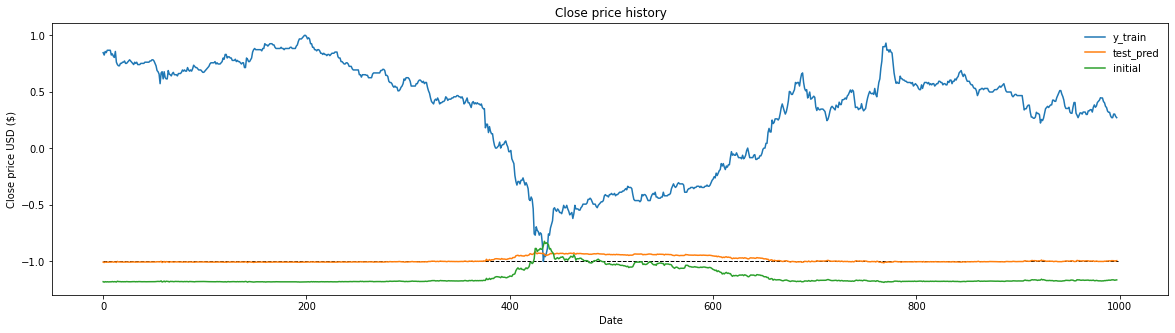

In [21]:
print('test_pred.shape =', test_pred.shape)

plt.figure(figsize=(20,5))
plt.title('Close price history')
plt.plot(data_reader.y_train, label = 'y_train')
plt.plot(test_pred, label = 'test_pred')
plt.plot(test_pred_initial, label = 'initial')
plt.xlabel('Date')
plt.ylabel('Close price USD ($)')
plt.hlines(trader.threshold, 0, data_reader.y_train.size, lw = 1, linestyles='dashed')
plt.legend(frameon=False)
plt.show()

## Plotter osztály

In [22]:
# ------------------------------------------------------------------------------    # <-- Plotter Class

class Plotter():

  def __init__(self):
    pass


  def plot_generation_scatter(self, generation_holder):

    m = np.zeros((len(generation_holder), len(generation_holder[0])))
    # print(m.shape)

    for i in range(len(generation_holder)):
      for j in range(len(generation_holder[i])):
        m[i, j] = generation_holder[i][j]

    # --- kell csinálni egy [0, 1, 2, ..., 0, 1, 2, ..., 0, 1, 2] vektort is az lesz majd az x -tengely
    n = np.arange(1, len(generation_holder) + 1, 1)
    a = []
    for _ in range(len(generation_holder[0])):
      a.append(n)
    b = np.array(a)
    c = b.flatten()

    # --- ki kell teríteni a mátrixba rakott score-okat és kész is
    s = m.flatten(order='C')
    s = m.flatten(order='F')

    # --- kiszűrni a végelenűl nagyokat (amelyknél nem volt értlemezhető scorre)      # <-- new in v.014

    f = np.zeros(s.shape)                                                             # <-- nincs jobb ötletem, minthogy 0-ra cserélem őket
    f[s > -maxsize + 1] = s[s > -maxsize + 1]

    # --- plot
    # plt.scatter(c, s)
    
    return c, s, f

# ------------------------------------------------------------------------------

  def plot_results(self, _max=None, _show_mid = False):
    if(_show_mid == True):
      fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(18, 5))
    else:
      fig, (a0, a2) = plt.subplots(1, 2, figsize=(12, 5))
    
    _number_of_generation = len(best_score_holder)
    if (_max == None):
      _number_of_generation = _number_of_generation
    elif (_max > _number_of_generation):
      _number_of_generation = _number_of_generation
    elif (_max < _number_of_generation):
      _number_of_generation = _max

    _x_axis = np.arange(1, _number_of_generation+1, 1)
    a0.scatter(_x_axis, best_score_holder[:_number_of_generation])
    a0.set_ylabel('Means Square Error')
    a0.set_xlabel('Generation')

    c, s, f = self.plot_generation_scatter(generation_holder[:_number_of_generation])

    if(_show_mid == True):
      #a1.plot(generation_holder[:_number_of_generation])
      a1.plot(f[:_number_of_generation])
      
      a1.set_xlabel('Generation')

    # a2.scatter(c, s)    # <-- nem szűrt adatok
    a2.scatter(c, f)    # <-- szűrt adatok

    a2.set_xlabel('Generation')
    plt.show()



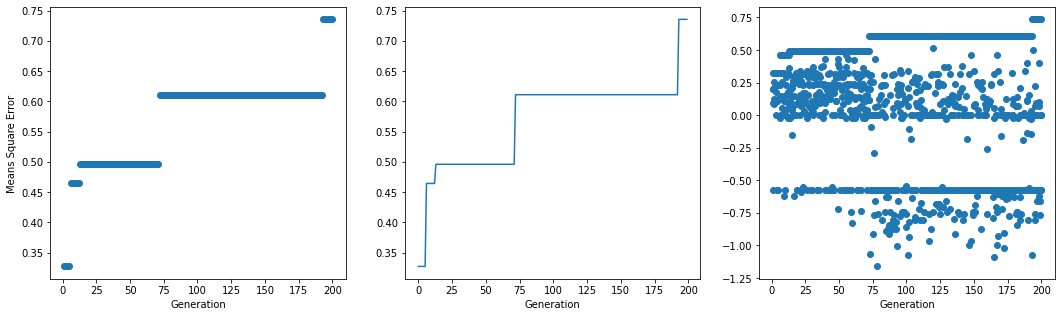

In [23]:
plotter = Plotter()

plotter.plot_results(2000, True)

## Evolver osztályt

- amiben azután propertyként tudok megadni változókat és irni rá settereket.
- legyen neki egy evaluate, vagy eval, vagy fit függvénye amit a mostani 'evaluate'

In [51]:
# ------------------------------------------------------------------------------    # <-- Evolver Class

import time
from enum import Enum
from sys import maxsize
from copy import deepcopy

class Backend(Enum):
  SCIKIT = 'scikit'
  KERAS = 'keras'

class NoneProperTypeError(Exception):
  print('Not Proper Type Error has been thrown.')
  pass

class Evaluator():
  """
  This is the Evaluator class which has to be instantiated for running sim.
  """

  def __init__(self, name: str, backend: Enum, arch: tuple, data_reader, nn):
    self.name = 'Evaluator'
    self.__id = 'id1'
    self.__backend = backend
    self.__arch = arch
    self.__print_generation = (False, 1)                                              # (True, 1) Minden generációra irja ki a best_individual_score-t
    self.__print_better = False                                                       # (False)   Ha talál jobb egyedet akkor írja ki
    self.data_reader = data_reader
    self.nn = nn

    self.__check(backend)
    self.__static()
  
  def run_evolution(self,
                    trader_threshold,
                    _generation,
                    _population,
                    _factor,
                    _keep_best):
    
    # --------------------------------------------------------------------------

    trader = Trader(threshold = trader_threshold, data_reader = self.data_reader)                                     # <-- create a Trader (0.0 just a random choise)
    randomer = Randomer(1)                                                            # <-- create a Randomer to controll the mutation
    randomer.debug = False
                                            
    generation = _generation                                                          # <----------- genetration (200)
    population = _population                                                          # <----------- population  (10)
    factor = _factor                                                                  # <----------- randomization factor (10)
    keep_best = _keep_best                                                            # <----------- keep_best (False)

    start_time = time.time()                                                          # <----------- mérjük meg, hogy mennyi ideig fut


    #
    np.random.seed(1)                                                                   # <-- (!)
    # ToDo: tesztelés után kivenni
    l1 = self.__arch[0]
    l2 = self.__arch[1]
    mlp = self.nn.init_nn(l1, l2)

    # mlp = init_nn(l1, l2)                                                           # <----------- itt adjuk át az MLP archtektúráját
    # ToDo: tesztelés után kivenni
    print('# Network intialization:')                                                 # ToDo: az init_nn függvényt át kell írnom, hogy tuple-t kapjon
    print('# First coefs')
    print('# ', mlp.coefs_[0][0])


    #
    coefs = deepcopy(mlp.coefs_)
    backup_mlp = deepcopy(mlp)
    working_mlp = deepcopy(mlp)

    best_generation_score = -maxsize
    best_generation_solution = None

    generation_holder = []
    population_holder = []
    best_indiv_holder = []
    best_score_holder = []

    # --------------------------------------------------------------------------

    for i in range(generation):                                                       # <-- generation loop
      # print('generation {}'.format(i))
      # a legjobb egyed
      best_individual_solution = None
      best_individual_score = best_generation_score

      population_holder = []
      best_indiv_holder = []


      for j in range(population):                                                     # <-- population loop
        # print('individal {}'.format(j))
        if( keep_best == True ):
          if( j == 0 ):                               # Ha keep_best és első elem a populációban, akor tartsa meg a régi súlyt -> ne randomizáljon
            a = coefs
            pass
          else:
            a = randomer.randomize(coefs, factor=factor)                                                  # <-- randomizálja a súlyokat
        else:
          a = randomer.randomize(coefs, factor=factor)                                                    # <-- randomizálja a súlyokat
        # ----------------------------------------------------------------------        # <-- vége a súlymutációnak
        
        working_mlp.coefs_ = a                                                          # <-- assigne randomized coefs to the working_model

        pred = working_mlp.predict(self.data_reader.x_train)                                             # <-- számolja ki a becslést

        result = trader.calculator(pred)                                                # <-- mérje vissza a hibát, számolja ki a keresekedéseket

        if result['buy_count'] != 0:                                                    # <-- le kell kezelni azt ha nincs kötés
          score = result['gain']                                                        # <-- csak akkor kapja meg az értéket ha volt vétel
        else:
          score = -maxsize                                                              # <-- egyébkként -maxsize (-9223372036854775807)

        # mindíg tartsa észbe, hogy ki volt a legjobb -> ezt tárolja le
        if( score > best_individual_score ):                                            # mivel maximalizálni akarunk ezért 'score > best_score'
          best_individual_score = score
          best_individual_solution = deepcopy(working_mlp)
          # print('new best_solution find individual = ', j)
          # print('i =', i, 'j =', j, '\tscore = ', score)
        
        # az éppen aktuális egyed score értékét tegyük el
        population_holder.append(score)
      
      # generációnként tároljuk le a legjobb egyed score érétkét
      best_score_holder.append(best_individual_score)

      # nyomonkövetés céljából tegyük le egy adott generáció összes egyedének scorját is
      generation_holder.append(population_holder)

      if( self.__print_generation[0] == True ):
          print('best_score in generation i = ', i, ' = ', best_individual_score)

      # ha a generáció legjobbja jobb mint a korábbi generáció legjobbja              # <-- ezt az értéket kell majd meghaladni a köv. gen.ben
      if ( best_individual_score > best_generation_score ):
        best_generation_score = best_individual_score
        best_generation_solution = deepcopy(best_individual_solution)
        found_better_in_generation = True
        # A generáció legjobbját tegyük le a coef változóba -> ezáltal a következő generációban ő lesz az ami alapján elindul a mutáció
        coefs = deepcopy(best_generation_solution.coefs_)

        if ( self.__print_better == True):
          print('better score have found in generation i = ', i, ' = ', best_individual_score)


    # A globalisan legjobb megoldás alapján csináljuk meg a becslést
    # test_pred = best_generation_solution.predict(x_train)                               # <-- kiértékeléshez és vizualizációhoz

    # A backup_mlp alapján kiszámolhatom, hogy imlyen volt a becslés eredetileg
    # test_pred_initial = backup_mlp.predict(x_train)                                     # > ha később össze akarom vetni valamelyik mutációval

    # Ezek kellenek a plottoláshoz
    # generation_holder, best_score_holder, best_generation_solution

    # Mérjük meg, hogy mennyi ideig futott
    running_time = time.time() - start_time
    print('running_time = {:.2f}'.format(running_time))
    print('------------------------------------------')

    # Amit vissza akarok kapni
    # Futási idő:                       running_time
    # A legjobb teljesítmény mértéke:   best_generation_score
    # A többi a plottoláshoz kell.

    return (running_time, best_generation_score, generation_holder, population_holder, best_indiv_holder, best_score_holder)


  # ----------------------------------------------------------------------------
  
  def __check(self, backend):
    if(isinstance(backend, Backend)):
      print('Backend is OK')
    else:
      print('Backend is not OK!')
  
  @classmethod
  def __static(self):
    print('Lefut a constructorban')

  def get_id(self) -> str:
    return self.__id

  def set_arch(self, arch: tuple):
    if type(arch) is tuple:
      self.__arch = arch
    else:
      raise NoneProperTypeError("Object is not set. Object is not is not 'Tuple' object.")

  def get_arch(self):
    return self.__arch

  def set_print_better(self, value: bool):
    if type(value) is bool:
      self.__print_better = value
    else:
      raise NoneProperTypeError("Object is not set. Object is not is not 'Boolean' object.")

  def set_print_generation(self, value: tuple):
    if type(value) is tuple:
      self.__print_generation = value
    else:
      raise NoneProperTypeError("Object is not set. Object is not is not 'Boolean' object.")
  
  def __str__(self):
        return 'Evaluator {0}, {1}, {2}, {3}'.format(self.name, self.__id, self.__backend, self.__arch)



Not Proper Type Error has been thrown.


## Program

In [52]:
# ------------------------------------------------------------------------------    # <-- Test The Program


exp_backend = Backend('scikit')
print(isinstance(exp_backend.SCIKIT, Backend))
evaluator = Evaluator('proba', backend=exp_backend, arch=(10,2), data_reader=data_reader, nn=nn)

evaluator.get_id()
evaluator.get_arch()
evaluator.set_arch((2,2))
evaluator.set_print_better(True)                                                    # <-- ! Vigyázat itt beállítottam
evaluator.set_print_generation((False, 1))                                          # <-- ! Vigyázat itt beállítottam
evaluator.get_arch()


# ------------------------------------------------------------------------------    # <-- Test The Program

# Population_size = 5
# Generation = 30

np.random.seed(1)

# ----------------

print(evaluator)

# exp_runtime, exp_fitness, exp_generation_holder, exp_population_holder, exp_best_indiv_holder, exp_best_score_holder = evolve(5, 30, True)

exp_runtime, exp_fitness, exp_generation_holder, exp_population_holder, exp_best_indiv_holder, exp_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0, _generation=5, _population=30, _factor=10, _keep_best=True)


print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)







True
Backend is OK
Lefut a constructorban
Evaluator Evaluator, id1, Backend.SCIKIT, (2, 2)
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.4643799472295882
better score have found in generation i =  1  =  0.4960422163588589
running_time = 0.33
------------------------------------------
exp_runtime =  0.3285386562347412
exp_fitness =  0.4960422163588589


## Expriment

Ahol azt vizsgálom, a populáció száma milyen hatással van a az eredményre.
Fontos, hogyha kevesebb populáció van, akkor azt tovább futtassuk.

In [53]:
# ------------------------------------------------------------------------------    # <-- Test The Program

# Population_size = 5
# Generation = 30

np.random.seed(1)

# ----------------

print(evaluator)

exp_runtime, exp_fitness, exp_generation_holder, exp_population_holder, exp_best_indiv_holder, exp_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=5,
                                                                                                                                               _population=30,
                                                                                                                                               _factor=10,
                                                                                                                                               _keep_best=True)


print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)


# Ezt azért végzem el, hogy két egymást követő futás után ugyan azt az eredményt adja-e?

# Verifikálva - Igen


# ------------------------------------------------------------------------------

# ha nincs keep best akkor a 5 gen 30 pop = 150 hívás

# ha nincs keep best akkor a 6 gen 30 pop = 180 hívás

# ha van keep best akkor a 5 gen 30 pop = 145 hívás  --> vagyis mindíg annyival kevesebb ahány generáció van

# ha van keep best akkor a 6 gen 30 pop = 174 hívás  --> vagyis mindíg annyival kevesebb ahány generáció van


# ------------------------------------------------------------------------------



Evaluator Evaluator, id1, Backend.SCIKIT, (2, 2)
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.4643799472295882
better score have found in generation i =  1  =  0.4960422163588589
running_time = 0.30
------------------------------------------
exp_runtime =  0.3002011775970459
exp_fitness =  0.4960422163588589


In [54]:
np.random.seed(1)

_g = 3                              # _generation
_p = 3                              # _population
_kb = True                          # _keep_best
_f = 10                             # _factor


exp_runtime, exp_fitness, exp_generation_holder, exp_population_holder, exp_best_indiv_holder, exp_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=_g,
                                                                                                                                               _population=_p,
                                                                                                                                               _factor=_f,
                                                                                                                                               _keep_best=_kb)

print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)



__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
running_time = 0.03
------------------------------------------
exp_runtime =  0.033135414123535156
exp_fitness =  0.3271767810026631


In [55]:

# Population_size = 6
# Generation = 200

# A teljes szám no_keep_best esetén 200 * 6 -> 1200
# A teljes szám keep_best esetén 200 * 6 - 200 -> 100

_g = 10                             # _generation
_p = 6                              # _population
_kb = False                         # _keep_best
_f = 10                             # _factor
_d = False                          # _debug

np.random.seed(1)

# ----------------

exp1_runtime, exp1_fitness, exp1_generation_holder, exp1_population_holder, exp1_best_indiv_holder, exp1_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=_g,
                                                                                                                                               _population=_p,
                                                                                                                                               _factor=_f,
                                                                                                                                               _keep_best=_kb)

print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)


__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.21108179419525186
better score have found in generation i =  1  =  0.43271767810028905
running_time = 0.17
------------------------------------------
exp_runtime =  0.033135414123535156
exp_fitness =  0.3271767810026631


In [56]:

# Population_size = 12
# Generation = 100

# A teljes szám no_keep_best esetén 100 * 12 -> 1200
# A teljes szám keep_best esetén 100 * 12 - 100 -> 1100

_g = 10                             # _generation
_p = 12                             # _population
_kb = False                         # _keep_best
_f = 10                             # _factor
_d = False                          # _debug

np.random.seed(1)

# ----------------

exp2_runtime, exp2_fitness, exp2_generation_holder, exp2_population_holder, exp2_best_indiv_holder, exp2_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=_g,
                                                                                                                                               _population=_p,
                                                                                                                                               _factor=_f,
                                                                                                                                               _keep_best=_kb)

print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)

__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  1  =  0.43271767810028905
better score have found in generation i =  2  =  0.4749340369393451
running_time = 0.29
------------------------------------------
exp_runtime =  0.033135414123535156
exp_fitness =  0.3271767810026631


In [57]:
# Population_size = 24
# Generation = 50

# A teljes szám no_keep_best esetén 50 * 24 -> 1200
# A teljes szám keep_best esetén 50 * 24 - 50 -> 1150

_g = 10                             # _generation
_p = 24                             # _population
_kb = False                         # _keep_best
_f = 10                             # _factor
_d = False                          # _debug

np.random.seed(1)

# ----------------

exp3_runtime, exp3_fitness, exp3_generation_holder, exp3_population_holder, exp3_best_indiv_holder, exp3_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=_g,
                                                                                                                                               _population=_p,
                                                                                                                                               _factor=_f,
                                                                                                                                               _keep_best=_kb)

print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)


__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.4643799472295882
better score have found in generation i =  2  =  0.4960422163588589
running_time = 0.46
------------------------------------------
exp_runtime =  0.033135414123535156
exp_fitness =  0.3271767810026631


In [58]:
# Population_size = 40
# Generation = 25

# A teljes szám no_keep_best esetén 25 * 48 -> 1200
# A teljes szám keep_best esetén 25 * 48 - 25 -> 1175

_g = 10                             # _generation
_p = 48                             # _population
_kb = False                         # _keep_best
_f = 10                             # _factor
_d = False                          # _debug

np.random.seed(1)

# ----------------

exp4_runtime, exp4_fitness, exp4_generation_holder, exp4_population_holder, exp4_best_indiv_holder, exp4_best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                                               _generation=_g,
                                                                                                                                               _population=_p,
                                                                                                                                               _factor=_f,
                                                                                                                                               _keep_best=_kb)

print('exp_runtime = ', exp_runtime)
print('exp_fitness = ', exp_fitness)


__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.5741424802110089
better score have found in generation i =  2  =  0.6564643799473231
better score have found in generation i =  9  =  0.682849604221559
running_time = 0.88
------------------------------------------
exp_runtime =  0.033135414123535156
exp_fitness =  0.3271767810026631


In [59]:
def plot_four():
  fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 5))


  _number_of_generation_exp1 = len(exp1_best_score_holder)
  _number_of_generation_exp2 = len(exp2_best_score_holder)
  _number_of_generation_exp3 = len(exp3_best_score_holder)
  _number_of_generation_exp4 = len(exp4_best_score_holder)

  _x_axis_exp1 = np.arange(1, _number_of_generation_exp1+1, 1)
  _x_axis_exp2 = np.arange(1, _number_of_generation_exp2+1, 1)
  _x_axis_exp3 = np.arange(1, _number_of_generation_exp3+1, 1)
  _x_axis_exp4  = np.arange(1, _number_of_generation_exp4 +1, 1)

  a0.scatter(_x_axis_exp1, exp1_best_score_holder[:_number_of_generation_exp1], label='population = 5, gen = 5000')
  a0.scatter(_x_axis_exp2, exp2_best_score_holder[:_number_of_generation_exp2], label='population = 10, gen = 2500')
  a0.scatter(_x_axis_exp3, exp3_best_score_holder[:_number_of_generation_exp3], label='population = 20, gen = 1250')
  a0.scatter(_x_axis_exp4, exp4_best_score_holder[:_number_of_generation_exp4], label='population = 40, gen = 625')

  a0.set_ylabel('Fitness')
  a0.set_xlabel('Generation')
  a0.legend(frameon=False)
  a0.set_title('Best ind. with cur. population size')

  point_size=0.9
  point_alha=0.9

  c, s, f_5_800 = plotter.plot_generation_scatter(exp1_generation_holder[:_number_of_generation_exp1])
  a1.scatter(c, f_5_800, alpha=point_alha, facecolors='C0', edgecolors='C0', s=point_size)

  c, s, f_10_400 = plotter.plot_generation_scatter(exp2_generation_holder[:_number_of_generation_exp2])
  a1.scatter(c, f_10_400, alpha=point_alha, facecolors='C1', edgecolors='C1', s=point_size)

  c, s, f_20_200 = plotter.plot_generation_scatter(exp3_generation_holder[:_number_of_generation_exp3])
  a1.scatter(c, f_20_200, alpha=point_alha, facecolors='C3', edgecolors='C2', s=point_size)

  c, s, f_40_100 = plotter.plot_generation_scatter(exp4_generation_holder[:_number_of_generation_exp4])
  a1.scatter(c, f_40_100, alpha=point_alha, facecolors='C3', edgecolors='C3', s=point_size)

  a1.set_xlabel('Generation')
  a1.set_title('All individuals in Generation')
  plt.show()


  print(exp1_best_score_holder[-1])
  print(exp2_best_score_holder[-1])
  print(exp3_best_score_holder[-1])
  print(exp4_best_score_holder[-1])

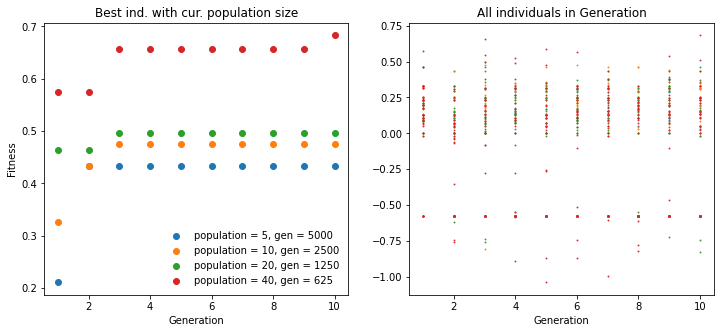

0.43271767810028905
0.4749340369393451
0.4960422163588589
0.682849604221559


In [60]:
plot_four()

## Baz

Vegyük le az első 100 esetet mindegyikből feszítsük ki és nézzük meg hogy milyen értéket adott

In [61]:
len(exp4_generation_holder)
len(exp4_generation_holder[0])
a1 = np.array(exp4_generation_holder)
a1.shape
b1 = a1.flatten()
b1.shape

(480,)

(10, 6) (60,)
(10, 12) (120,)
(10, 24) (240,)
(10, 48) (480,)
(60,)


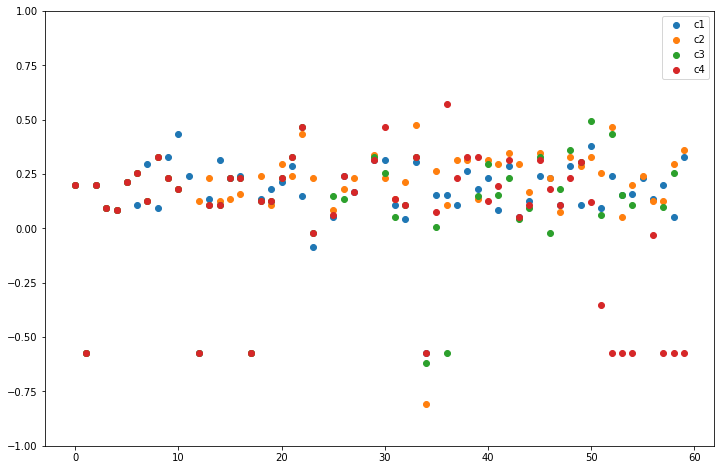

In [62]:

a1 = np.array(exp1_generation_holder)
b1 = a1.flatten()
a2 = np.array(exp2_generation_holder)
b2 = a2.flatten()
a3 = np.array(exp3_generation_holder)
b3 = a3.flatten()
a4 = np.array(exp4_generation_holder)
b4 = a4.flatten()
print(a1.shape, b1.shape)
print(a2.shape, b2.shape)
print(a3.shape, b3.shape)
print(a4.shape, b4.shape)


size = 60
line = np.arange(0, size, 1)
print(line.shape)


c1 = b1[:size]
c2 = b2[:size]
c3 = b3[:size]
c4 = b4[:size]
plt.figure(figsize=(12,8))
plt.scatter(line, c1, label='c1')
plt.scatter(line, c2, label='c2')
plt.scatter(line, c3, label='c3')
plt.scatter(line, c4, label='c4')
plt.ylim((-1,1))
plt.legend()
plt.show()

## Fent

A 7.ik lépésben a c1 (pop size = 6) elmegy és új értéket vesz fel
A 13.ik lépésben a c2 (pop size = 12) elmegy és új értéket vesz fel
A 25.ik lépseben a c3 (pop size = 24) elmegy és új értéket vesz fel

Érdekes módon akkor válnak szét ezek az értékek amikor meghaladják a populációs mérétküket. A kérdés, hogy miért?

Rossz helyen írom ki őket?
Elvileg mindíg ugyan azokat a súlyokat tesztelik.

Lehet, hogy akkor van a hiba amikor beírom a teljesítményűket letároló listába?

Vagy korábban!

Hiszen a mutáció úgy néz ki, hogy best értékhez ad hozzá egy véletlen számot.
És a best érték mindíg akkor lép érvénybe amikor generáció váltás van.

MEGVAN A MEGOLDÁS!

Itt volt a hiba.

A best értékhez adja hozzá ugyan azokat a véletlen számokat.
De ami 6 egyedes, az a hetedik lépésben megkaja meg a best értéket.
És onnantól ugyan az a véletlen szám lesz hozzáadva mint 12 egyedes (7.ik egyedéhez) csak annak egy régi best értéke van. Ezért a kettő ugyan azt az új véletlen számot kapja csak az egyik még a régihez adja hozzá, a másik meg már egy újhoz.

Ez a probléma akkor nem jelentkezett volna, hogyha egy individum generáción belül elér egy best értéket akkor felülcsapja az egész populációra vonakozó best értéket.

Tehát jól csináltam csak nem értettem a működést amit pedig én írtam.

## Ez ugyanakkor felvet egy fontos kérdést. Vagy mégsem?

Ha szekvenciálisan egy gépen futtatom, akkor amint lefut egy indivídum tudni fogjuk, hogy jobb eredményt ért-e el mint a generáció addigi legjobbja. Ezért flül tudjuk csapni a paramétereivel a gént és a következő egyednek már ez alapján kéne mutálódnia. Ez azonban azt jelentené, hogy minden egyed aki megdönti a korábbi rekordot azonnal szülővé válik és a következő egyedet már belőle klónozzuk, majd mutáljuk.

A klasszikus EA-ban viszont ez nem így működik.<br>
Ott végig megyünk az összes egyeden a populációban és csak a végén nézzük meg, hogy ki volt a legjobb. Majd ez alapján áll elő az új populáció, a legjobb alapján.

Ezt az esetetet könnyen lehet párhuzamosítani.<br>
Viszont ha az van amit korábban írtam, hogy bármelyik egyed elér egy jobb eredményt mint bármely korábbi volt, akkor értesítenie kéne a többi párhuzamosan futót és megkérdezni, hogy mi a ti eredményetek, hogy felül tudjam írni, be tudjam írni a rekordot. Szóval ez az eset **nem párhuzamosítható**.

Peidg korábban tök véletlenül így írtam meg a program és ezt hibának véltam. Az is a klasszikus EA értelmében.

Ugyhogy lehet, hogy mégsem írtam akkora hülyeséget a cikkben, hogy a nagyobb populáció szám - ha klasszikus és párhuzamosítható EA-t vesszük - esetében **nem biztos, hogy jobb eredményre vezet a nagyobb populáció szám** mert **később mutálódnak** vagy ha úgy jobban tetszik, **később tudják átadni a mutációs előnyt** kevesebb *reprodukció* van.



## A nagy elemszámú populációs vizsgálatok. (Teszt)

Most sokkal nagyobb populáció számmal próbálom ki ugyan azokat a kísérleteket amiket a cikkbe írtam.

In [63]:
# ------------------------------------------------------------------------------


experiment_popsize = {'exp1': ({"pop_size": 10}, 1), 'exp2': ({"pop_size": 20}, 2)}   # <-- set experiments

print(len(experiment_popsize))
print(experiment_popsize.keys())

exp_results = []

for i in experiment_popsize.keys():                                                   # <-- iterate through experiments
  print(i)
  exp_population_size = experiment_popsize.get(i)[0].get('pop_size')
  exp_id = experiment_popsize.get(i)[1]
  print(exp_population_size)


  # ---                                                                               # <-- here is the experiment itself

  # Population_size = __                                                              # <-- gets from 'pop_size'
  # Generation = 10

  # --- seed
  np.random.seed(1)

  # --- run EA
  
  runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                         _generation=10,
                                                                                                                         _population=exp_population_size,
                                                                                                                         _keep_best=True,
                                                                                                                         _factor=10)
  
  exp_result = [runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder, exp_id, exp_population_size]

  exp_results.append(exp_result)


2
dict_keys(['exp1', 'exp2'])
exp1
10
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  2  =  0.4643799472295882
better score have found in generation i =  5  =  0.4960422163588589
running_time = 0.24
------------------------------------------
exp2
20
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  1  =  0.5741424802110089
better score have found in generation i =  5  =  0.6564643799473231
running_time = 0.36
------------------------------------------


In [64]:
def plot_exp(_exp_results):
  fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 5))

  for exp in _exp_results:
    _number_of_generation_exp = len(exp[5])

    _x_axis_exp = np.arange(1, _number_of_generation_exp+1, 1)

    a0.scatter(_x_axis_exp, exp[5][:_number_of_generation_exp], label='population = ' + str(exp[7]) + ', gen = 5000')

    a0.set_ylabel('Fitness')
    a0.set_xlabel('Generation')
    a0.legend(frameon=False)
    a0.set_title('Best ind. with cur. population size')

    point_size=1.9
    point_alha=0.9

    c, s, f = plotter.plot_generation_scatter(exp[2][:_number_of_generation_exp])
    a1.scatter(c, f, alpha=point_alha, s=point_size)

    a1.set_xlabel('Generation')
    a1.set_title('All individuals in Generation')
    
    print('fitness of exp{} = {}'.format(exp[6], exp[1]))

  plt.show()


fitness of exp1 = 0.4960422163588589
fitness of exp2 = 0.6564643799473231


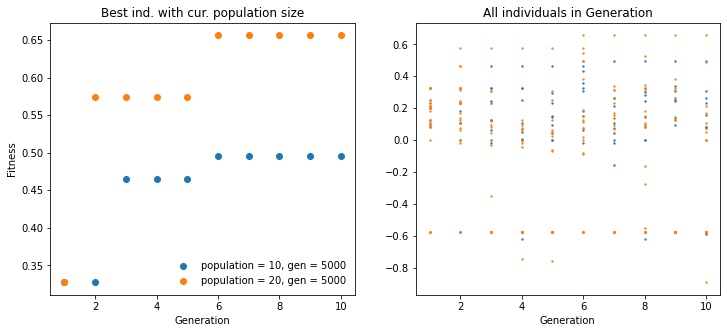

In [65]:
plot_exp(exp_results)

## A nagy elemszámú populációs vizsgálatok. (Ráhangolódás)

Most sokkal nagyobb populáció számmal próbálom ki ugyan azokat a kísérleteket amiket a cikkbe írtam.

In [66]:
# ------------------------------------------------------------------------------


from numpy.random import RandomState

prng = RandomState(1234567890)

experiment_popsize = {'exp1': ({'pop_size': 10, 'gen_size': 14}, 1),
                      'exp2': ({'pop_size': 20, 'gen_size': 10}, 2),
                      'exp3': ({'pop_size': 30, 'gen_size': 10}, 3)}   # <-- set experiments

print(len(experiment_popsize))
print(experiment_popsize.keys())

exp_results = []

for i in experiment_popsize.keys():                                                   # <-- iterate through experiments
  print(i)
  exp_population_size = experiment_popsize.get(i)[0].get('pop_size')
  exp_generation_size = experiment_popsize.get(i)[0].get('gen_size')
  exp_id = experiment_popsize.get(i)[1]
  print(exp_population_size)


  # ---                                                                               # <-- here is the experiment itself

  # Population_size = __                                                              # <-- gets from 'pop_size'
  # Generation = 10

  # --- seed
  np.random.seed(1)

  # --- run EA
  
  runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                        _generation=exp_generation_size,
                                                                                                                        _population=exp_population_size,
                                                                                                                        _keep_best=True,
                                                                                                                        _factor=10)

  exp_result = [runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder, exp_id, exp_population_size]

  exp_results.append(exp_result)


3
dict_keys(['exp1', 'exp2', 'exp3'])
exp1
10
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  2  =  0.4643799472295882
better score have found in generation i =  5  =  0.4960422163588589
running_time = 0.30
------------------------------------------
exp2
20
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  1  =  0.5741424802110089
better score have found in generation i =  5  =  0.6564643799473231
running_time = 0.36
------------------------------------------
exp3
30
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.4643799472295882
better score have found in generation i =  1  =  0.4960422163588589
better score hav

fitness of exp1 = 0.4960422163588589
fitness of exp2 = 0.6564643799473231
fitness of exp3 = 0.6110817941952291


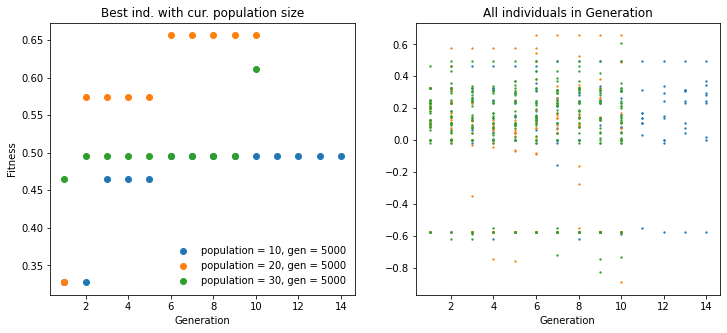

In [67]:
plot_exp(exp_results)

## A nagy elemszámú populációs vizsgálatok. (Valós)

Most sokkal nagyobb populáció számmal próbálom ki ugyan azokat a kísérleteket amiket a cikkbe írtam.

In [68]:
# ------------------------------------------------------------------------------


from numpy.random import RandomState

prng = RandomState(1234567890)

experiment_popsize = {'exp1': ({'pop_size': 10, 'gen_size': 100}, 1),
                      'exp2': ({'pop_size': 25, 'gen_size': 100}, 2),
                      'exp3': ({'pop_size': 50, 'gen_size': 100}, 3),
                      'exp4': ({'pop_size': 99, 'gen_size': 100}, 4)}   # <-- set experiments

print(len(experiment_popsize))
print(experiment_popsize.keys())

exp_results = []

for i in experiment_popsize.keys():                                                   # <-- iterate through experiments
  print(i)
  exp_population_size = experiment_popsize.get(i)[0].get('pop_size')
  exp_generation_size = experiment_popsize.get(i)[0].get('gen_size')
  exp_id = experiment_popsize.get(i)[1]
  print(exp_population_size)


  # ---                                                                               # <-- here is the experiment itself

  # Population_size = __                                                              # <-- gets from 'pop_size'
  # Generation = 10

  # --- seed
  np.random.seed(1)

  # --- run EA
  
  runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                        _generation=exp_generation_size,
                                                                                                                        _population=exp_population_size,
                                                                                                                        _keep_best=True,
                                                                                                                        _factor=10)

  exp_result = [runtime, fitness, generation_holder, population_holder, best_indiv_holder, best_score_holder, exp_id, exp_population_size]

  exp_results.append(exp_result)


4
dict_keys(['exp1', 'exp2', 'exp3', 'exp4'])
exp1
10
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  2  =  0.4643799472295882
better score have found in generation i =  5  =  0.4960422163588589
better score have found in generation i =  31  =  0.6110817941952291
better score have found in generation i =  85  =  0.735620052770372
running_time = 1.77
------------------------------------------
exp2
25
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.4643799472295882
better score have found in generation i =  2  =  0.4960422163588589
better score have found in generation i =  11  =  0.6110817941952291
better score have found in generation i =  32  =  0.735620052770372
better score have found in generation i =  61  =  0.7641160949867185
running_time = 4.35
----

fitness of exp1 = 0.735620052770372
fitness of exp2 = 0.7641160949867185
fitness of exp3 = 0.7852242744062892
fitness of exp4 = 0.7852242744062892


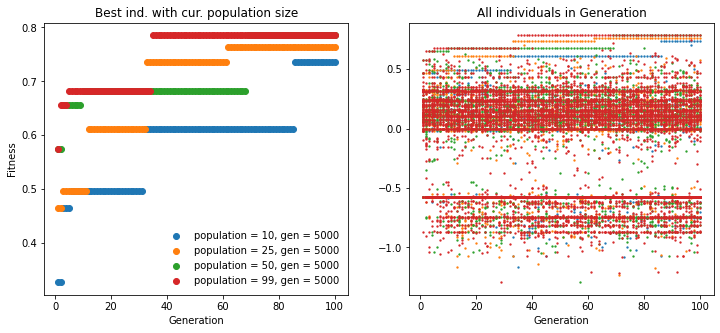

In [69]:
plot_exp(exp_results)

## Experiment

Ahol a mutáció mértékének a tanulásra gyakorolt hatását vizsgálom meg.

In [70]:

rt_holder = []
g_holder = []
p_holder = []
bi_holder = []
bs_holder = []

exp_generation_size = 500
exp_population_size = 10
exp_keep_best = True

factors = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
for i, v in enumerate(factors):
  print(i, v)

  runtime, fitt, generation_holder, population_holder, best_indiv_holder, best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                      _generation=exp_generation_size,
                                                                                                                      _population=exp_population_size,
                                                                                                                      _keep_best=exp_keep_best,
                                                                                                                      _factor=v)
  rt_holder.append(runtime)
  g_holder.append(generation_holder)
  p_holder.append(population_holder)
  bi_holder.append(best_indiv_holder)
  bs_holder.append(best_score_holder)


0 1
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  1  =  0.3377308707123916
better score have found in generation i =  4  =  0.4749340369393451
better score have found in generation i =  11  =  0.4960422163588589
better score have found in generation i =  20  =  0.5298153034300128
better score have found in generation i =  22  =  0.5857519788918069
better score have found in generation i =  28  =  0.6511873350922315
better score have found in generation i =  31  =  0.7176781002637824
better score have found in generation i =  48  =  0.7810026385223523
better score have found in generation i =  112  =  0.9234828496041416
better score have found in generation i =  325  =  0.9625329815301598
running_time = 8.87
------------------------------------------
1 2
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
bet

better score have found in generation i =  107  =  0.5403693931397129
better score have found in generation i =  109  =  0.589973614775829
better score have found in generation i =  111  =  0.6353562005276387
better score have found in generation i =  203  =  0.6532981530343136
better score have found in generation i =  297  =  0.7936675461740208
running_time = 8.79
------------------------------------------
12 16
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
better score have found in generation i =  0  =  0.3271767810026631
better score have found in generation i =  2  =  0.43271767810028905
better score have found in generation i =  5  =  0.4960422163588589
better score have found in generation i =  15  =  0.5688654353561446
better score have found in generation i =  16  =  0.5773087071239615
better score have found in generation i =  20  =  0.5984168865435038
better score have found in generation i =  31  =  0.6068601583113207
better score have

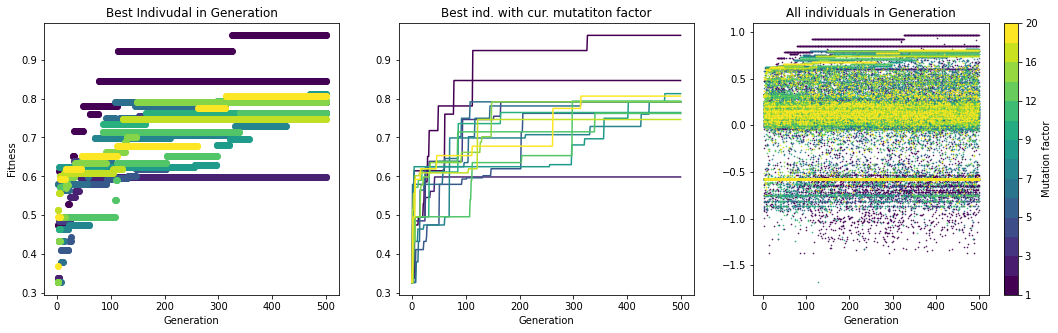

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
# print(viridis(0))

color_factor = 1/len(factors)

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(18, 5))

for i, v in enumerate(factors):
  best_score_holder = bs_holder[i]
  generation_holder = g_holder[i]

  _number_of_generation = len(best_score_holder)

  _x_axis = np.arange(1, _number_of_generation+1, 1)

  _color = viridis(i * color_factor)

  a0.scatter(_x_axis, best_score_holder[:_number_of_generation], color=_color, label='factor = ' + str(v))

  a0.set_ylabel('Fitness')
  a0.set_xlabel('Generation')
  a0.set_title('Best Indivudal in Generation')
  # a0.legend(frameon=False)

  point_size=0.4
  point_alha=0.9

  c, s, f = plotter.plot_generation_scatter(generation_holder[:_number_of_generation])

  a1.plot(f[:_number_of_generation], color = _color)  
  a1.set_xlabel('Generation')
  a1.set_title('Best ind. with cur. mutatiton factor')
  
  a2.scatter(c, f, alpha=point_alha, s=point_size, color = _color, label=str(v))

  a2.set_xlabel('Generation')
  a2.set_title('All individuals in Generation')

cmap = mpl.cm.viridis
# bounds = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
bounds = factors
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical',
             label='Mutation factor');

plt.show()

## Ha teljesen üres kimenetet akarok

Elég a már meglévő Evolveren átállítani egy értéket

In [71]:
evaluator.set_print_better(False)

In [72]:

rt_holder = []
g_holder = []
p_holder = []
bi_holder = []
bs_holder = []

exp_generation_size = 500
exp_population_size = 10
exp_keep_best = True

factors = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
for i, v in enumerate(factors):
  print(i, v)

  runtime, fitt, generation_holder, population_holder, best_indiv_holder, best_score_holder = evaluator.run_evolution(trader_threshold=-1.0,
                                                                                                                      _generation=exp_generation_size,
                                                                                                                      _population=exp_population_size,
                                                                                                                      _keep_best=exp_keep_best,
                                                                                                                      _factor=v)
  rt_holder.append(runtime)
  g_holder.append(generation_holder)
  p_holder.append(population_holder)
  bi_holder.append(best_indiv_holder)
  bs_holder.append(best_score_holder)


0 1
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.93
------------------------------------------
1 2
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.80
------------------------------------------
2 3
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.75
------------------------------------------
3 4
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.78
------------------------------------------
4 5
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.93
------------------------------------------
5 6
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
running_time = 8.79
------------------------------------------
6 7
__init__ Trader
# Network intialization:
# First coefs
#  [-0.20325375  0.53968259]
runnin

## Visualise net - Best Solution

In [76]:
!pip install palette

  Preparing metadata (setup.py) ... done
  Created wheel for palette: filename=palette-0.2-py3-none-any.whl size=5982 sha256=da9a1ca70fe3acba458f544d1c32d87fde1bb9f5c0adfc63e2f25f8ac3b606c2
  Stored in directory: /home/ubuntu/.cache/pip/wheels/d3/dd/de/6b02b7da1c1d0205e45bc81fbbc0224c021a2e9d1d9e4e595c
Successfully built palette


In [79]:
import os

os.system('rm MLPPlot.py')
os.system('wget https://raw.githubusercontent.com/JoDeMiro/Micado-Research/main/MLPPlot.py')

import MLPPlot

net = best_generation_solution                                                      # <- a best_solution

num_input_varialbe = ['X']

num_input_varialbe = ['X'+str(i) for i in range(30)]

num_input_varialbe = ['X'+str(i) for i in range(net.coefs_[0].shape[0])]            # <- mlp.coefs_[0].shape[0] a bemenetek száma



# Define the structure of the network
network_structure = np.hstack(([len(num_input_varialbe)], np.asarray(net.hidden_layer_sizes), [1]))

print(network_structure)

# Draw the Neural Network with weights
network = MLPPlot.DrawNN(network_structure, net.coefs_, num_input_varialbe)
network.draw()

--2022-03-08 16:57:12--  https://raw.githubusercontent.com/JoDeMiro/Micado-Research/main/MLPPlot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11442 (11K) [text/plain]
Saving to: ‘MLPPlot.py’

     0K .......... .                                          100% 9.33M=0.001s

2022-03-08 16:57:12 (9.33 MB/s) - ‘MLPPlot.py’ saved [11442/11442]



ModuleNotFoundError: No module named 'palettable'

## Visualise net - Initial ('Empty') Solution

[2 2 2 1]


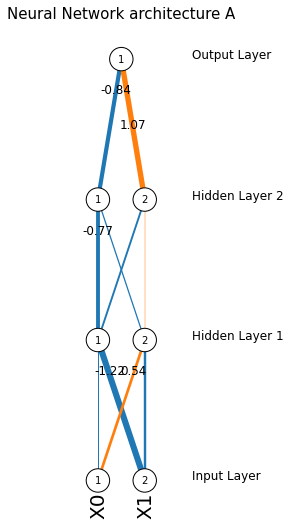

In [145]:
import os

os.system('rm MLPPlot.py')
os.system('wget https://raw.githubusercontent.com/JoDeMiro/Micado-Research/main/MLPPlot.py')

import MLPPlot

net = backup_mlp                                                                    # <- a kiinduló megoldást vesszük sorra

num_input_varialbe = ['X']

num_input_varialbe = ['X'+str(i) for i in range(30)]

num_input_varialbe = ['X'+str(i) for i in range(net.coefs_[0].shape[0])]            # <- mlp.coefs_[0].shape[0] a bemenetek száma



# Define the structure of the network
network_structure = np.hstack(([len(num_input_varialbe)], np.asarray(net.hidden_layer_sizes), [1]))

print(network_structure)

# Draw the Neural Network with weights
network = MLPPlot.DrawNN(network_structure, net.coefs_, num_input_varialbe)
network.draw()


```
# JoDeMiro
```
